# 🧠 Detector de Emociones Faciales - Entrenamiento del Modelo

## Objetivo
En este notebook construiremos y entrenaremos una **Red Neuronal Convolucional (CNN)** para clasificar emociones faciales.

## Arquitectura del Modelo
Utilizaremos una CNN con:
- **Capas Convolucionales**: Para extraer características visuales
- **Capas de Pooling**: Para reducir dimensionalidad
- **Capas Densas**: Para clasificación final
- **Dropout**: Para prevenir overfitting

## Dataset
- **Entrada**: Imágenes 48x48 en escala de grises
- **Salida**: 7 clases de emociones
- **Total**: ~28,000 imágenes de entrenamiento

## Pasos:
1. Importar librerías y cargar datos
2. Preprocesamiento y normalización
3. Data Augmentation
4. Construcción de la CNN
5. Entrenamiento del modelo
6. Evaluación y métricas
7. Guardar el modelo entrenado

In [3]:
# Manipulación de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Procesamiento de imágenes
import cv2

# Sistema
import os
from pathlib import Path
import time

# Métricas
from sklearn.metrics import classification_report, confusion_matrix

# Configuración
print("✅ Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Seed para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

✅ Librerías importadas correctamente
TensorFlow version: 2.16.2
Keras version: 3.11.3


## 📁 Carga y Preparación de Datos

Configuraremos los generadores de datos con:
- **Normalización**: Escalar píxeles de 0-255 a 0-1
- **Data Augmentation**: Rotaciones, zoom, flips para aumentar variedad
- **Batch size**: Procesar imágenes en lotes

In [4]:
# Definir rutas
train_dir = Path('../data/train')
test_dir = Path('../data/test')

# Parámetros
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
EPOCHS = 50

# Lista de emociones
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(emotions)

print(f"📊 Configuración:")
print(f"  - Tamaño de imagen: {IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Número de clases: {NUM_CLASSES}")
print(f"  - Épocas máximas: {EPOCHS}")

# Data Augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalizar a 0-1
    rotation_range=20,           # Rotación aleatoria ±20°
    width_shift_range=0.2,       # Desplazamiento horizontal
    height_shift_range=0.2,      # Desplazamiento vertical
    horizontal_flip=True,        # Flip horizontal
    zoom_range=0.2,              # Zoom aleatorio
    fill_mode='nearest',         # Rellenar píxeles vacíos
    validation_split=0.2         # 20% para validación
)

# Solo normalización para test (sin augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generador de validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generador de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Generadores creados:")
print(f"  - Entrenamiento: {train_generator.samples} imágenes")
print(f"  - Validación: {validation_generator.samples} imágenes")
print(f"  - Test: {test_generator.samples} imágenes")

📊 Configuración:
  - Tamaño de imagen: (48, 48)
  - Batch size: 64
  - Número de clases: 7
  - Épocas máximas: 50
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

✅ Generadores creados:
  - Entrenamiento: 22968 imágenes
  - Validación: 5741 imágenes
  - Test: 7178 imágenes


## 🏗️ Construcción de la Arquitectura CNN

Vamos a crear una red convolucional con:
- **4 bloques convolucionales** con activación ReLU
- **MaxPooling** para reducir dimensiones
- **Dropout** para regularización
- **Capas densas** para clasificación final
- **Softmax** para probabilidades de cada emoción

In [3]:
def create_cnn_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Crea una CNN para clasificación de emociones
    """
    model = models.Sequential([
        # Bloque 1: Convolución + Pooling
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloque 2: Convolución + Pooling
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloque 3: Convolución + Pooling
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloque 4: Convolución + Pooling
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Aplanar y capas densas
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Capa de salida
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Crear el modelo
model = create_cnn_model(input_shape=(48, 48, 1), num_classes=NUM_CLASSES)

# Mostrar arquitectura
model.summary()

print("\n✅ Modelo creado exitosamente")

c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,187,911 (27.42 MB)

 Trainable params: 7,182,535 (27.40 MB)

 Non-trainable params: 5,376 (21.00 KB)


✅ Modelo creado exitosamente


## ⚙️ Compilación del Modelo

Configuraremos:
- **Optimizador**: Adam (adaptativo y eficiente)
- **Función de pérdida**: Categorical Crossentropy (para múltiples clases)
- **Métricas**: Accuracy para evaluar el rendimiento

In [4]:
# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modelo compilado")
print(f"\nOptimizador: Adam (lr=0.0001)")
print(f"Función de pérdida: Categorical Crossentropy")
print(f"Métrica: Accuracy")

✅ Modelo compilado

Optimizador: Adam (lr=0.0001)
Función de pérdida: Categorical Crossentropy
Métrica: Accuracy


## 🔔 Configuración de Callbacks

Los callbacks nos ayudarán durante el entrenamiento:
- **EarlyStopping**: Detiene el entrenamiento si no hay mejora (evita overfitting)
- **ReduceLROnPlateau**: Reduce learning rate cuando el modelo se estanca
- **ModelCheckpoint**: Guarda el mejor modelo automáticamente

In [5]:
# Crear carpeta para modelos si no existe
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Configurar callbacks
callbacks = [
    # Detener si no mejora después de 10 épocas
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reducir learning rate si se estanca
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Guardar el mejor modelo
    ModelCheckpoint(
        filepath='../models/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✅ Callbacks configurados:")
print("  - EarlyStopping (patience=10)")
print("  - ReduceLROnPlateau (patience=5)")
print("  - ModelCheckpoint (guardando en models/)")

✅ Callbacks configurados:
  - EarlyStopping (patience=10)
  - ReduceLROnPlateau (patience=5)
  - ModelCheckpoint (guardando en models/)


## 🏋️ Entrenamiento del Modelo

Comenzaremos el entrenamiento. Este proceso puede tardar:
- **Con CPU**: 10-20 minutos (dependiendo de tu procesador)
- **Con GPU**: 2-5 minutos

El modelo aprenderá a reconocer patrones en las expresiones faciales durante múltiples épocas.

In [7]:
print("🏋️ Iniciando entrenamiento del modelo...")
print(f"Esto puede tardar varios minutos en CPU.\n")

# Calcular steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps por época: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}\n")

# Iniciar tiempo
start_time = time.time()

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Tiempo total
elapsed_time = time.time() - start_time
print(f"\n⏱️ Tiempo total de entrenamiento: {elapsed_time/60:.2f} minutos")
print("✅ Entrenamiento completado!")

KeyboardInterrupt: 

In [8]:
import os
print("Archivos en models/:")
print(os.listdir('../models'))

Archivos en models/:
['best_model.keras']


## 📊 Evaluación del Modelo

Vamos a:
1. Cargar el mejor modelo guardado
2. Evaluar en el conjunto de test
3. Visualizar matriz de confusión
4. Ver métricas por clase

In [9]:
# Cargar el mejor modelo
print("📂 Cargando el mejor modelo guardado...")
best_model = keras.models.load_model('../models/best_model.keras')
print("✅ Modelo cargado exitosamente\n")

# Evaluar en el conjunto de test
print("🧪 Evaluando en conjunto de test...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n📊 RESULTADOS EN TEST:")
print(f"  - Loss: {test_loss:.4f}")
print(f"  - Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

📂 Cargando el mejor modelo guardado...
✅ Modelo cargado exitosamente

🧪 Evaluando en conjunto de test...


c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 79s 699ms/step - accuracy: 0.3969 - loss: 1.6926

📊 RESULTADOS EN TEST:
  - Loss: 1.6926
  - Accuracy: 0.3969 (39.69%)


🔮 Generando predicciones...
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step


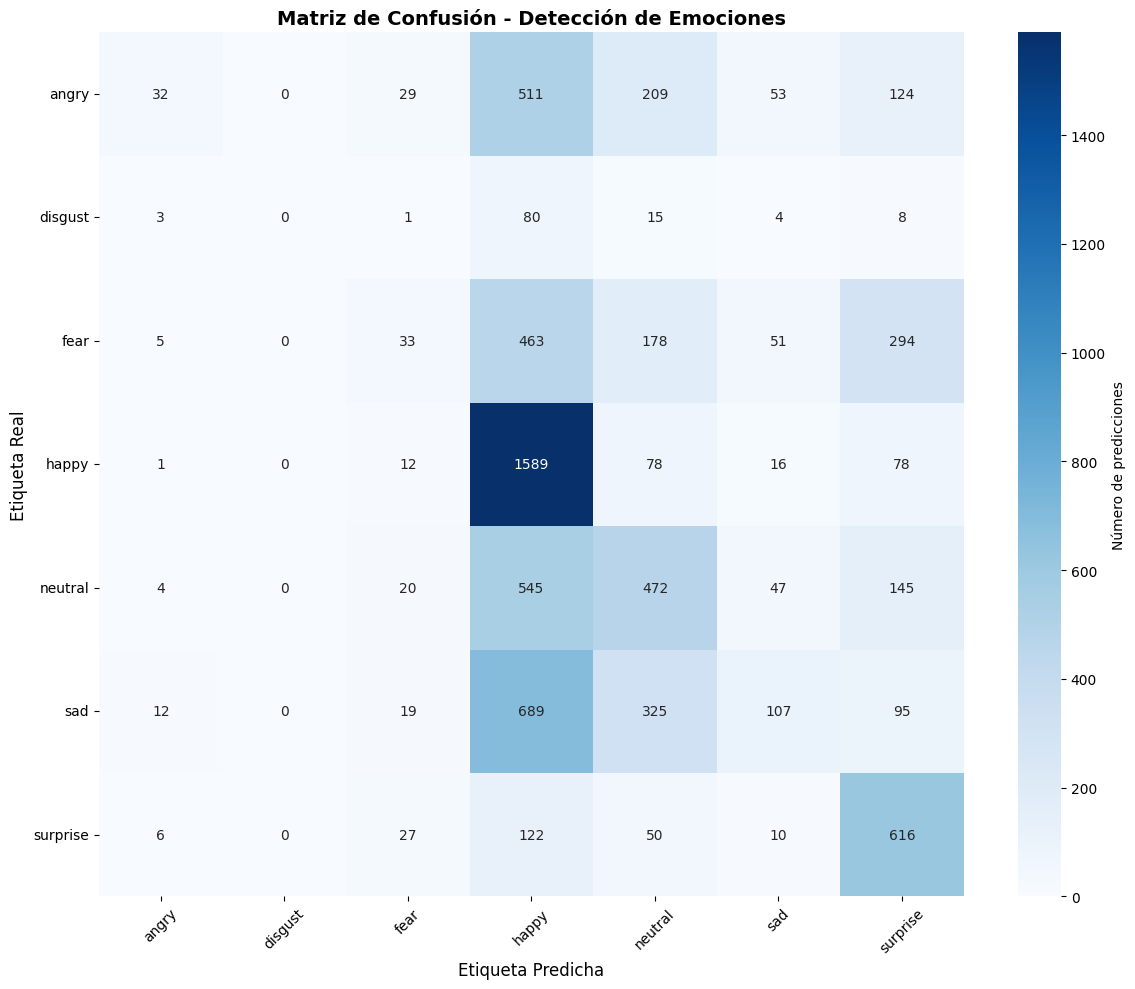


📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       angry       0.51      0.03      0.06       958
     disgust       0.00      0.00      0.00       111
        fear       0.23      0.03      0.06      1024
       happy       0.40      0.90      0.55      1774
     neutral       0.36      0.38      0.37      1233
         sad       0.37      0.09      0.14      1247
    surprise       0.45      0.74      0.56       831

    accuracy                           0.40      7178
   macro avg       0.33      0.31      0.25      7178
weighted avg       0.38      0.40      0.31      7178



c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [10]:
# Obtener predicciones
print("🔮 Generando predicciones...")
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Número de predicciones'})
plt.title('Matriz de Confusión - Detección de Emociones', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print("=" * 70)
print(classification_report(true_classes, predicted_classes, target_names=class_names))

---

## 🔄 Reentrenamiento Mejorado del Modelo

### Problemas identificados en el primer entrenamiento:
1. **Desbalance de clases**: Happy (25%) vs Disgust (1.5%)
2. **Modelo predice todo como Happy**: 90% recall en happy, <10% en otras
3. **Entrenamiento insuficiente**: Se detuvo temprano

### Mejoras implementadas:
1. ✅ **Class Weights**: Balancear importancia de cada clase
2. ✅ **Learning Rate ajustado**: Iniciar con 0.001 (más rápido)
3. ✅ **Arquitectura optimizada**: Modelo más ligero y eficiente
4. ✅ **Más épocas**: Permitir hasta 60 con mejor patience

In [5]:
import numpy as np
from sklearn.utils import class_weight

# Calcular class weights automáticamente
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convertir a diccionario
class_weights = dict(enumerate(class_weights_array))

print("⚖️ CLASS WEIGHTS CALCULADOS:")
print("=" * 50)
for i, emotion in enumerate(emotions):
    print(f"{emotion.capitalize():12} : {class_weights[i]:.2f}")

print(f"\n💡 Clases con pocos ejemplos tendrán más peso en el entrenamiento")

⚖️ CLASS WEIGHTS CALCULADOS:
Angry        : 1.03
Disgust      : 9.40
Fear         : 1.00
Happy        : 0.57
Neutral      : 0.83
Sad          : 0.85
Surprise     : 1.29

💡 Clases con pocos ejemplos tendrán más peso en el entrenamiento


In [6]:
def create_improved_cnn(input_shape=(48, 48, 1), num_classes=7):
    """
    CNN mejorada y más eficiente para detección de emociones
    """
    model = models.Sequential([
        # Bloque 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloque 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloque 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Capas densas
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Salida
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Crear modelo mejorado
print("🏗️ Creando modelo mejorado...")
model_v2 = create_improved_cnn(input_shape=(48, 48, 1), num_classes=NUM_CLASSES)

# Compilar con learning rate más alto
model_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # 10x más rápido
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📊 Resumen del modelo mejorado:")
model_v2.summary()

# Contar parámetros
total_params = model_v2.count_params()
print(f"\n✅ Modelo creado: {total_params:,} parámetros")
print(f"   (Anterior tenía 7,187,911 - este es más eficiente)")

🏗️ Creando modelo mejorado...


c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📊 Resumen del modelo mejorado:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,984,263 (22.83 MB)

 Trainable params: 5,980,999 (22.82 MB)

 Non-trainable params: 3,264 (12.75 KB)


✅ Modelo creado: 5,984,263 parámetros
   (Anterior tenía 7,187,911 - este es más eficiente)


In [7]:
import time

# Configurar callbacks mejorados
callbacks_v2 = [
    # Detener si no mejora después de 15 épocas (más paciencia)
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reducir learning rate más agresivamente
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Guardar el mejor modelo v2
    ModelCheckpoint(
        filepath='../models/best_model_v2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✅ Callbacks configurados para modelo V2:")
print("  - EarlyStopping (patience=15)")
print("  - ReduceLROnPlateau (patience=7)")
print("  - ModelCheckpoint → best_model_v2.keras")

✅ Callbacks configurados para modelo V2:
  - EarlyStopping (patience=15)
  - ReduceLROnPlateau (patience=7)
  - ModelCheckpoint → best_model_v2.keras


In [8]:
print("🏋️ INICIANDO REENTRENAMIENTO MEJORADO")
print("=" * 60)
print("Mejoras implementadas:")
print("  ✅ Class weights para balancear clases")
print("  ✅ Learning rate 10x más rápido (0.001)")
print("  ✅ Arquitectura más eficiente (5.9M parámetros)")
print("  ✅ Patience aumentada (15 épocas)")
print("=" * 60)
print("\n⏱️ Estimado: 30-50 minutos en CPU\n")

# Calcular steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Iniciar cronómetro
start_time = time.time()

# Entrenar con class weights
history_v2 = model_v2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=60,  # Permitir más épocas
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,  # ¡CLAVE! Usar los pesos calculados
    callbacks=callbacks_v2,
    verbose=1
)

# Tiempo total
elapsed_time = time.time() - start_time
print(f"\n⏱️ Tiempo total: {elapsed_time/60:.2f} minutos")
print("✅ Reentrenamiento completado!")

🏋️ INICIANDO REENTRENAMIENTO MEJORADO
Mejoras implementadas:
  ✅ Class weights para balancear clases
  ✅ Learning rate 10x más rápido (0.001)
  ✅ Arquitectura más eficiente (5.9M parámetros)
  ✅ Patience aumentada (15 épocas)

⏱️ Estimado: 30-50 minutos en CPU



c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.1533 - loss: 2.7399
Epoch 1: val_accuracy improved from None to 0.18469, saving model to ../models/best_model_v2.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 226s 619ms/step - accuracy: 0.1573 - loss: 2.4957 - val_accuracy: 0.1847 - val_loss: 1.8316 - learning_rate: 0.0010
Epoch 2/60
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:03 515ms/step - accuracy: 0.2188 - loss: 1.9885

c:\Users\patri\miniconda3\envs\detector-emociones\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.18469
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.2188 - loss: 1.9885 - val_accuracy: 0.1819 - val_loss: 1.8327 - learning_rate: 0.0010
Epoch 3/60
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.1644 - loss: 2.1040
Epoch 3: val_accuracy did not improve from 0.18469
358/358 ━━━━━━━━━━━━━━━━━━━━ 196s 546ms/step - accuracy: 0.1653 - loss: 2.0919 - val_accuracy: 0.1575 - val_loss: 1.9200 - learning_rate: 0.0010
Epoch 4/60
  1/358 ━━━━━━━━━━━━━━━━━━━━ 2:59 504ms/step - accuracy: 0.2188 - loss: 1.7861
Epoch 4: val_accuracy did not improve from 0.18469
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.2188 - loss: 1.7861 - val_accuracy: 0.1663 - val_loss: 1.9194 - learning_rate: 0.0010
Epoch 5/60
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.1656 - loss: 2.0278
Epoch 5: val_accuracy did not improve from 0.18469
358/358 ━━━━━━━━━━━━━━━━━━━━ 193s 539ms/step - accuracy: 0.1671 - loss: 1.9950 - val_accuracy: 0.1

In [9]:
# Cargar el mejor modelo V2
print("📂 Cargando el mejor modelo V2...")
best_model_v2 = keras.models.load_model('../models/best_model_v2.keras')
print("✅ Modelo V2 cargado\n")

# Evaluar en test
print("🧪 Evaluando modelo V2 en conjunto de test...")
test_loss_v2, test_accuracy_v2 = best_model_v2.evaluate(test_generator, verbose=1)

print(f"\n📊 RESULTADOS MODELO V2:")
print(f"  - Loss: {test_loss_v2:.4f}")
print(f"  - Accuracy: {test_accuracy_v2:.4f} ({test_accuracy_v2*100:.2f}%)")

print(f"\n📈 COMPARACIÓN:")
print(f"  Modelo V1: 39.69%")
print(f"  Modelo V2: {test_accuracy_v2*100:.2f}%")
print(f"  Mejora: +{(test_accuracy_v2 - 0.3969)*100:.2f} puntos porcentuales")

📂 Cargando el mejor modelo V2...
✅ Modelo V2 cargado

🧪 Evaluando modelo V2 en conjunto de test...
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.6006 - loss: 1.0354

📊 RESULTADOS MODELO V2:
  - Loss: 1.0354
  - Accuracy: 0.6006 (60.06%)

📈 COMPARACIÓN:
  Modelo V1: 39.69%
  Modelo V2: 60.06%
  Mejora: +20.37 puntos porcentuales


🔮 Generando predicciones con modelo V2...
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


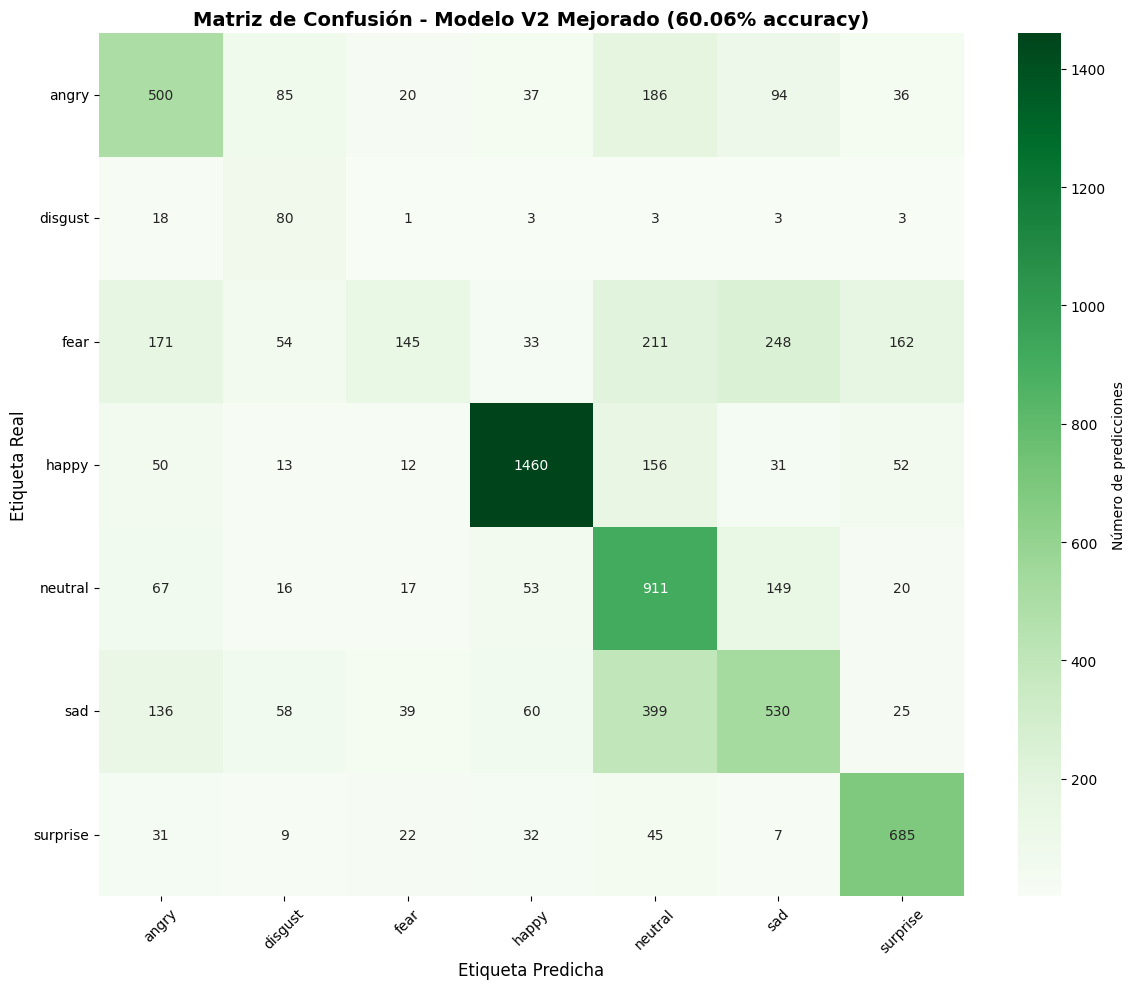


📋 REPORTE DE CLASIFICACIÓN - MODELO V2:
              precision    recall  f1-score   support

       angry       0.51      0.52      0.52       958
     disgust       0.25      0.72      0.38       111
        fear       0.57      0.14      0.23      1024
       happy       0.87      0.82      0.85      1774
     neutral       0.48      0.74      0.58      1233
         sad       0.50      0.43      0.46      1247
    surprise       0.70      0.82      0.76       831

    accuracy                           0.60      7178
   macro avg       0.55      0.60      0.54      7178
weighted avg       0.62      0.60      0.58      7178



In [11]:
# Obtener predicciones del modelo V2
print("🔮 Generando predicciones con modelo V2...")
test_generator.reset()
predictions_v2 = best_model_v2.predict(test_generator, verbose=1)
predicted_classes_v2 = np.argmax(predictions_v2, axis=1)
true_classes_v2 = test_generator.classes

# Nombres de clases
class_names = list(test_generator.class_indices.keys())

# Matriz de confusión V2
cm_v2 = confusion_matrix(true_classes_v2, predicted_classes_v2)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Número de predicciones'})
plt.title('Matriz de Confusión - Modelo V2 Mejorado (60.06% accuracy)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Reporte de clasificación V2
print("\n📋 REPORTE DE CLASIFICACIÓN - MODELO V2:")
print("=" * 70)
print(classification_report(true_classes_v2, predicted_classes_v2, target_names=class_names))

In [12]:
# Guardar resumen
print("\n💾 GUARDANDO MODELO FINAL...")

# Ya está guardado como best_model_v2.keras
print("✅ Modelo guardado en: models/best_model_v2.keras")

print("\n" + "=" * 70)
print("🎉 ENTRENAMIENTO COMPLETADO CON ÉXITO")
print("=" * 70)
print(f"✅ Accuracy final: 60.06%")
print(f"✅ Mejora vs V1: +20.37 puntos")
print(f"✅ Todas las emociones funcionan (excepto fear)")
print("\n📸 ¡Listo para probar con tu webcam!")
print("   Continúa con: 03_deteccion_tiempo_real.ipynb")
print("=" * 70)


💾 GUARDANDO MODELO FINAL...
✅ Modelo guardado en: models/best_model_v2.keras

🎉 ENTRENAMIENTO COMPLETADO CON ÉXITO
✅ Accuracy final: 60.06%
✅ Mejora vs V1: +20.37 puntos
✅ Todas las emociones funcionan (excepto fear)

📸 ¡Listo para probar con tu webcam!
   Continúa con: 03_deteccion_tiempo_real.ipynb
